In [2]:
# %matplotlib inline
import matplotlib.pyplot as plt
import os, re
import time
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
from scipy.fftpack import fft, ifft

import stfft
import general
import eegFilter
from eegAnalysis import EEGAnalysis

from tqdm import tqdm

```python
            "delta":(  2,  4),
            "theta":(  4,  8),
            "alpha":(  8, 12),
            "beta": ( 15, 30),
            "gamma":( 30,150),
            "low gamma": (30, 80),
            "high gamma":(80,150),
            "lowpass":(1,200),
            "highpass":(200,500)
```

In [13]:
datadir = "../../Data"
resultdir = "../../Result/"
# patientName = "Chen Zhou"
patientName = "Demo"
fs = 2000

# targetfiles = "180904-2-5"
targetfiles = "999999-9-9"
chidx = 105
cutoffband = "lowpass"
lowcut, highcut = eegFilter.getbandrange(cutoffband)

##### set target files #####
# files = []
# matching_pattern = r"\d{6}-.*?\.mat"
# for item in os.listdir(os.path.join(datadir, patientName, "EEG", "Compact")):
#     if re.match(matching_pattern, item):
#         possibleResultFile = os.path.splitext(item)[0] + ".csv"
#         if not os.path.exists(os.path.join(resultdir, patientName, possibleResultFile)):
#             files.append(os.path.splitext(item)[0])

print("file:", targetfiles, '\nchannel:',chidx+1, '\nbandpass:', cutoffband)
analysis = EEGAnalysis(
        datadir = datadir,
        resultdir = resultdir,
        patientname = patientName,
        expname = targetfiles,
        fs=fs,
        roi=(-2,5))

file: 999999-9-9 
channel: 106 
bandpass: lowpass


CPU times: user 2.76 s, sys: 461 ms, total: 3.22 s
Wall time: 3.23 s


<Figure size 432x288 with 0 Axes>

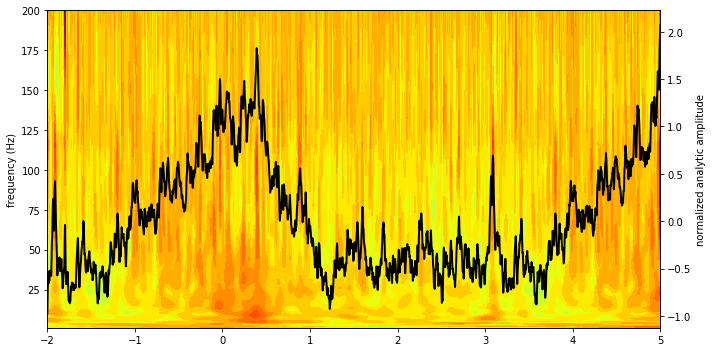

In [20]:
frange = np.logspace(np.log10(lowcut), np.log10(highcut), 40)
tspec = np.linspace(analysis.roi[0], analysis.roi[-1], (analysis.roi[1] - analysis.roi[0])*analysis.fs)
# baseroi = (1,2)
cue_onset = analysis.markers["grating"][0][0][0,:]
ch_split = general.split_datawithmarker(analysis.channels[chidx, :], cue_onset, 
                                        analysis.roi, analysis.fs)
%time pxx = stfft.dwt_tf(ch_split, analysis.fs, frange, reflection=True, zscore=True)


plt.figure()
fig, ax1 = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)

cont = ax1.contourf(np.linspace(-2,5,3500), frange, pxx[:,::4], 40, cmap=plt.get_cmap("jet"))
ax1.set_xlim([tspec[0], tspec[-1]])
ax1.set_ylabel("frequency (Hz)")
# cont.set_clim(-1, 2)

ax2 = ax1.twinx()
ax2.plot(tspec, np.mean(pxx,0),'k', linewidth=2)
ax2.set_ylabel("normalized analytic amplitude")

fig.tight_layout()
plt.show()

# tf domain
# plt.contourf(np.linspace(-2,5,3500), frange, pxx[:,::4], 40, cmap=plt.get_cmap("jet"))
# # plt.clim([0,4])
# plt.show()

plt.close('all')